##  SURNAME: ________ NAME: _________

In [6]:
#from __future__ import division # uncomment this if using Python 2.7
import numpy as np
import math
from scipy import signal, spatial
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature, util, io
from sklearn import metrics

%matplotlib inline
from IPython.display import HTML, display

# Feature matching



In this lab we are going to dive deeper into <i>image matching</i>, specifically on a local approach based on features correspondances. 

We first consider the simplest situation possible: the image pairs we consider are related by simple transformations, therefore we will make the following choices:
1. Feature detector: corners (with the shi-tomasi algorithm)
2. Feature description: patches around the corner (size $w\times w$)
3. Matching strategy: affinity matrix with a similarity measure of choice


The parameters of every intermediate step, must be specified as input arguments. Try with different distance metrics (e.g. euclidean, correlation, squared euclidean) and with all three image pairs (Rubik, Shrub, Phone)

## Let us define the main functions

We first write a function that extracts patches of image around each corner (w.r.t. the patch size, that is a parameter)
* First we need to pad our image, adding a surrounding frame of appropriate width. In this way even border features (like the red one in the drawing) will have their neighbourhood

Then, for each corner, 
* we adjust the corner coordinates with respect to the new padded image I_ext
* we extract the size_w X size_w patch surrounding the corner (check the range notation)
* we flatten the patch to form a 1D feature vector of size 2*size_w and save it in a list


<img src="week2_lab_notes.png" width="500">

In [31]:
def patch_descriptor(I, corner_pos, size_w):
    """Extract square patches around each corner on an input grayscale image. 
    - I: input RGB image
    - corner_pos: list with position of n corners (row,col)
    - size_w: (integer) patch side
   """
    
    n = len(corner_pos) # Number of features
    hw = int(np.floor(size_w/2)) # half size of the patch (useful to center the pat)
    I_ext = util.pad(I, hw, 'reflect') # pad the image with a frame of width hw 
    
    # initialize patches list
    patches = np.zeros([n,(2*hw+1)**2])
    
    for i in range(0, n):
        
        r = corner_pos[i,0]+hw # adjust the row of each corner considering the padding
        c = corner_pos[i,1]+hw # do the same for the column 
        tmp = I_ext[r-hw:r+hw+1,c-hw:c+hw+1] # estract the patch
        patches[i,:] = tmp.flatten() #flatten the patch and save it in the patches list
        
    return patches


Implement the function that computes the feature matching procedure.
Assuming we have $m$ features in image 1 and $n$ features in image 2, the affinity matrix will have size $m\times n$.
For each feature in image 1, we will be matching the one in image 2 <i>minimizes</i> the distance.

Below you find a simple version of the procedure  
1. First compute the affinity matrix 
2. Then detect the maxima of the affinity matrix
3. Derive che corresponding matches
4. Return the matches and the affinity matrix

**Hint:** First check <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html">`spatial.distance.cdist`</a> from `scipy` module, with Euclidean metric.
Then use the formulae below to compute the elements of an affinity matrix (values in the range [0,1]
$\exp^{-d(f_i,g_j)/2\sigma^2}$ ) 



In [32]:
def spectral_matching(sigma, patches1, patches2,corner_pos1,corner_pos2):
    
    # evaluate the distance among patches
    D = spatial.distance.cdist(patches1,patches2, metric='euclidean')
    # compute the affinity matrix using the exponent formulation
    E = np.exp(-D//(2*sigma*sigma))
    # find the minimum distace
    argmaxE = np.argmax(E, axis=1)
    # plot the matching pairs (match includes the match from corner_pos2 associated with corner_pos1)
    match = corner_pos2[argmaxE,:]
    
    return E, match

Write a function that plots the images side-by-side and superimposes the features (<b>hint:</b> beware of the offset!) and a line connecting the matched pairs 

In [33]:
def show_match(match,corner_pos1,corner_pos2,img1, img2):
    """show match on side-by-side images"""
    
    img= np.concatenate([img1,img2],axis=1)
    plt.imshow(img, cmap=cm.gist_gray)
    
    for i in range(0, len(corner_pos1)):
        plt.plot([corner_pos1[i,1], match[i,1]+img1.shape[1]], [corner_pos1[i,0], match[i,0]],'y')
        
    plt.scatter(corner_pos1[:,1], corner_pos1[:,0], s=10, c='r')
    plt.scatter(corner_pos2[:,1]+img1.shape[1], corner_pos2[:,0], s=20, c='b')
    
    return img    

## Let us test the feature matching pipeline

We start with a simple image pair. We first load them and visualize them

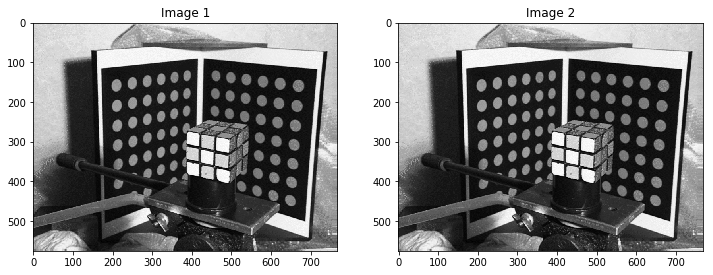

In [34]:
# LOAD IMAGES
RGBimg1 = io.imread('images/Rubik1.pgm')
img1 = img_as_float(color.rgb2gray(RGBimg1))

RGBimg2 = io.imread('images/Rubik1.pgm')
img2 = img_as_float(color.rgb2gray(RGBimg2))
 
#PLOT THEM
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(RGBimg1, cmap=cm.gist_gray)
plt.title('Image 1')
plt.subplot(122)
plt.imshow(RGBimg2, cmap=cm.gist_gray)
plt.title('Image 2');


Now, let us identify the corners by using the shi tomasi algorithm implemented in skimage

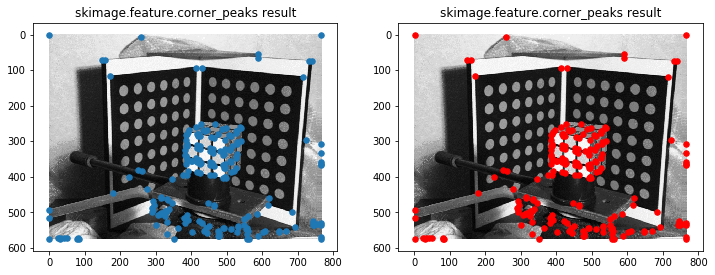

In [35]:
# FEATURE DETECTION
# using the shi-tomasi algorithm, identify the corners in both images

corners1 = feature.corner_peaks(feature.corner_shi_tomasi(img1))
corners2 = feature.corner_peaks(feature.corner_shi_tomasi(img2))

# plot the results on both images side by side
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(RGBimg1, cmap=cm.gist_gray)
plt.scatter(corners1[:,1], corners1[:,0], s=30)
plt.title('skimage.feature.corner_peaks result')

plt.subplot(122)
plt.imshow(RGBimg2, cmap=cm.gist_gray)
plt.scatter(corners2[:,1], corners2[:,0], s=30, c='r')
plt.title('skimage.feature.corner_peaks result');

In [36]:
# FEATURE DESCRIPTORS
patches1 = patch_descriptor(img1, corners1, 40)
patches2 = patch_descriptor(img2, corners2, 40)

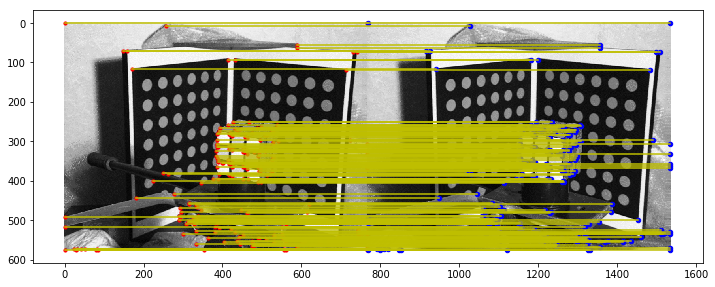

In [37]:
# FEATURE MATCHING
plt.figure(figsize=(12,6))
D,match = spectral_matching(0.5,patches1, patches2, corners1, corners2)
match_euclidean = show_match(match,corners1,corners2,img1, img2)

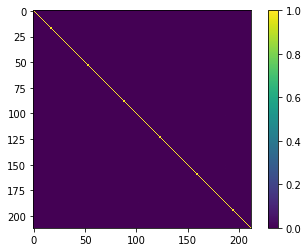

In [38]:
# LET US ALSO HAVE A LOOK AT THE AFFINITY MATRIX
plt.imshow(D) 
plt.colorbar()

### Improvements
There are a number of improvement you could consider at some point. Below you find a mandatory improvement and some optional ones
1.  The function spectral_matching does not compute the maxima in the correct way; <i>correct the function</i> so that the identified feature pairs are maxima of both rows and colums . 

Optionally you may also have a look at the following
1. spectral_matching: you may add a threshold on the distance, setting to 0 the affinity matrix entries below a threshold(see theory)
2. In the affinity matrix computation, one could also include an evaluation on the position of
features (close features should be favoured if we have a prior on image similarity). Again, see theory
2. Corners on the border of the image should be discarded as they tend to be less reliable.


### Experiments
Here are some experiments you should carry out. Add code snippets and comments below. Conclude with a final discussion section.
- Debug n. 0 is to use the same image for img1 and img2. Answer before proceeding: what do you expect to find? Check the Affinity Matrix
- How to proceed if you want to obtain fewer corners?
- Now try out with two different images of the same object, again analyse the matches as well as the affinity matrix. Try out different sigma values: are the results in line with your expectations?  
- now  "break" the simple matching procedure by applying appropriate image transformations: use, as inputs, I1 and transformed(I1), where transformed may be:
    - small or large translations
    - small or large rotations
    - small or large zoom in

- To be sure you fully grasp the concepts, you should try out other image pairs (see the Images folder)



In [ ]:
### code code code 

### Add your final discussion here !
Be concise and specific